# Natural Computing

## Assignment 2: Swarm Intelligence

## Exercise 3

*Source paper*

Van der Merwe, D. W., and Andries Petrus Engelbrecht.  "Data clustering using particleswarm optimization". Evolutionary Computation, 2003.  CEC’03.  The 2003 Congresson. Vol. 1. IEEE, 2003.

In [1]:
# Imports
import numpy as np
from operator import itemgetter
from sklearn import datasets
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Load Iris dataset
Features X:

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm 

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
print('X shape:', X.shape) # 150 records, 4 features
print('Classes:', np.unique(y)) # 3 classes

X shape: (150, 4)
Classes: [0 1 2]


In [3]:
def plot_iris(X, y, title=None):
    # stack features and classes
    data = np.hstack((X, np.expand_dims(y, axis=1)))
    # convert numpy array to pandas dataframe
    iris_pd = pd.DataFrame(data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])
    iris_pd['class'] = iris_pd['class'].astype(int)
    # plot
    plot_sns = sns.pairplot(iris_pd, hue='class', palette="husl", markers=["o", "s", "D"])
    plot_sns.fig.set_size_inches(8, 8)
    plot_sns.fig.suptitle(title, size=14, y=1.05)

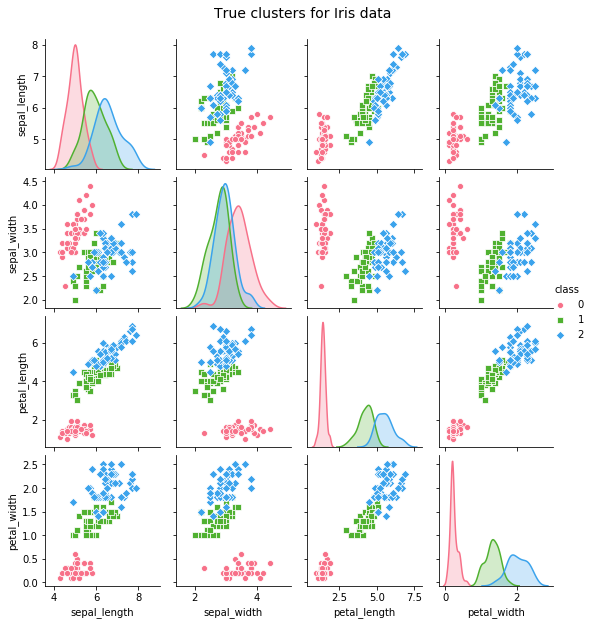

In [4]:
plot_iris(X, y, 'True clusters for Iris data')

#### Artificial dataset 1

In [5]:
def artificial_dataset(N):
    """Artificial dataset 1"""
    X, Y = [], []
    np.random.seed(42)
    for _ in range(N):
        z1, z2  = np.random.uniform(-1, 1, 2)
        if z1 >= 0.7 or ( z1 <= 0.3 and (z2 >= -0.2-z1) ):
            y = 1
        else:
            y = 0
        X.append([z1, z2])
        Y.append(y)
    return np.asarray(X), np.asarray(Y)

In [6]:
# N=400 data vectors in the paper
X_AD, y_AD = artificial_dataset(400)
X_AD.shape

(400, 2)

In [7]:
def plot_artificial(X, y, title=None, centers=None):
    plt.figure(figsize=(7, 7))
    idx0 = np.where(y == 0)[0]
    idx1 = np.where(y == 1)[0]
    plt.scatter(X[idx0, 0], X[idx0, 1], c='tab:red', marker='+', label='class 0')
    plt.scatter(X[idx1, 0], X[idx1, 1], c='tab:blue', marker='x', label='class 1')
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)    
    plt.xlabel('$z1$')
    plt.ylabel('$z2$')
    plt.title(title, size=14)
    plt.legend()
    plt.show()

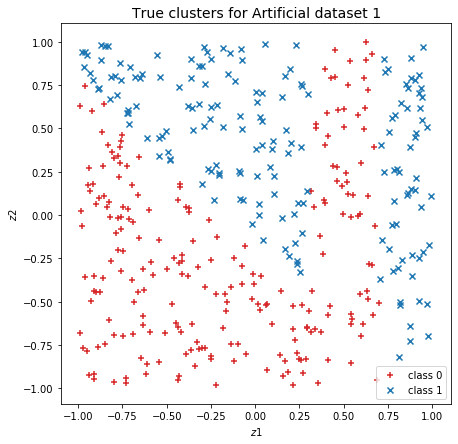

In [8]:
plot_artificial(X_AD, y_AD, 'True clusters for Artificial dataset 1')

### PSO clustering algorithm

Quality is measured according to the following three criteria (according to the paper):
- the quantization error
- the intra-cluster distances, i.e. the distance between data vectors within a cluster, where the objective is to minimize the intra-cluster distances
- the inter-clus!er distances, i.e. the distance between the centroids of the clusters, where the objective is to maximize the distance between clusters

In [73]:
"""
Alternative code to fix the problem that empty clusters are learned 
by forcing at least one data point to be assigned to each cluster centroid.
The data point closest to the empty cluster centroid is assigned to that cluster.
"""
# def force_non_empty_clusters(assigned_centroids, centroid_dists, N_c):
#     """
#     Helper function to force non-empty clusters by assigning 
#     at least one data point closest to the centroid of empty clusters.
#     """
#     empty_cluster_ids = [cluster_id for cluster_id in range(N_c) 
#                          if cluster_id not in set(assigned_centroids)]        
#     for cluster_id in empty_cluster_ids:
#         min_idx = np.argmin(centroid_dists[cluster_id])
#         assigned_centroids[min_idx] = cluster_id            
#     return assigned_centroids  

# def assign_centroids(data, centroids, allow_empty=True):
#     """Assign datapoints to closest cluster centroids."""
#     # calculate distance of data point z to each centroid c
#     centroid_dists = []
#     for centroid in centroids:
#         centroid_dists.append( [euclidean(z, centroid) for z in data] )
#     centroid_dists = np.asarray(centroid_dists)    
    
#     # assign z to the centroid with minimal distance
#     assigned_centroids = np.argmin(centroid_dists, axis=0)    
#     if allow_empty:
#         return assigned_centroids, centroid_dists
#     else:
#         assigned_centroids = force_non_empty_clusters(assigned_centroids, centroid_dists, len(centroids))
#         return assigned_centroids, centroid_dists

# def quantization_error(data, centroids, allow_empty=True):
#     """Fitness function for cluster quality."""
#     N_c = len(centroids) # number of cluster centroids 
    
#     assigned_centroids, centroid_dists = assign_centroids(data, centroids, allow_empty) 
#     assigned_centroid_dists = []
#     for cluster_id in range(N_c):
#         cluster_idx = np.where(cluster_id == assigned_centroids)[0]
#         assigned_centroid_dist = centroid_dists[cluster_id][cluster_idx]
#         assigned_centroid_dists.append(assigned_centroid_dist)
        
#     dists = assigned_centroid_dists # alias
#     error = np.sum( [np.sum( dists[j]/len(dists[j]) ) 
#                      for j in range(N_c)] ) / N_c
#     return error

In [9]:
def assign_centroids(data, centroids):
    """Assign datapoints to closest cluster centroids."""
    # calculate distance of data point z to each centroid c
    centroid_dists = []
    for centroid in centroids:
        centroid_dists.append( [euclidean(z, centroid) for z in data] )
    centroid_dists = np.asarray(centroid_dists)    
    
    # assign z to the centroid with minimal distance
    assigned_centroids = np.argmin(centroid_dists, axis=0)    
    return assigned_centroids, centroid_dists

def quantization_error(data, centroids):
    """Fitness function for cluster quality."""
    N_c = len(centroids) # number of cluster centroids 
    
    assigned_centroids, centroid_dists = assign_centroids(data, centroids) 
    assigned_centroid_dists = []
    for cluster_id in range(N_c):
        cluster_idx = np.where(cluster_id == assigned_centroids)[0]
        assigned_centroid_dist = np.asarray([np.inf]) # empty clusters are penalized
        if len(cluster_idx):
            assigned_centroid_dist = centroid_dists[cluster_id][cluster_idx]
        assigned_centroid_dists.append(assigned_centroid_dist)
        
    dists = assigned_centroid_dists # alias
    error = np.sum( [np.sum( dists[j]/len(dists[j]) ) 
                     for j in range(N_c)] ) / N_c
    return error

In [51]:
class Particle:
    def __init__(self, data, n_clusters):
        self.n_clusters = n_clusters
        self.pos = np.asarray( [self._sample_centroid(data) for _ in range(n_clusters)] ) # position
        self.vel = np.zeros( self.pos.shape ) # velocity
        self.lbest = (None, np.inf) # initialize local best to worst value
        self.threshold = 1e-100 # threshold to be considered stationary
        self.stationary_count = 0 # number of times the velocity is below the threshold
    
    @staticmethod
    def _sample_centroid(data):
        """Sample centroids with lower and upper bounds from data."""
        _, dim = data.shape # centroid dimension
        min_val = data.min(axis=0) # lower bounds
        max_val = data.max(axis=0) # upper bounds  
        return [np.random.uniform(min_val[d], max_val[d]) for d in range(dim)]    
    
    def evaluate(self, data):
        """Compute fitness and update local best."""
        # compute fitness (error) of the particle
        error = quantization_error(data, self.pos)

        # update local best if equal or better
        _, lbest_error = self.lbest
        if error <= lbest_error:
            self.lbest = (self.pos.copy(), error)
            
    def update(self, omega, c1, c2, r1, r2, gbest):
        """Update particle."""       
        lbest_pos, _ = self.lbest
        gbest_pos, _ = gbest

        inertia = omega * self.vel
        cognitive = c1 * r1 * (lbest_pos - self.pos);
        social = c2 * r2 * (gbest_pos - self.pos);
        
        self.vel = inertia + cognitive + social
        if np.sum(self.vel) < self.threshold:
            self.stationary_count += 1
        self.pos += self.vel

In [52]:
class Swarm:
    def __init__(self, data, n_clusters, n_particles, omega, c1, c2):
        self.data = data
        self.n_clusters = n_clusters
        self.particles = np.asarray([Particle(data, n_clusters) for _ in range(n_particles)])
        self.gbest = (None, np.inf) # initialize global best to worst value
        self.omega = omega
        self.c1 = c1
        self.c2 = c2
        self.history = []
    
    def __len__(self):
        return len(self.particles)
    
    def evaluate(self):
        """
        Evaluate swarm by updating local best 
        for each particle and the swarm global best.
        """
        # update local best
        for particle in self.particles:
            particle.evaluate(self.data)
        
        # update global best
        lbests = [particle.lbest for particle in self.particles]
        best_local_pos, best_local_error = min(lbests, key=itemgetter(1))
        _, gbest_error = self.gbest
        if best_local_error <= gbest_error:
            self.gbest = (best_local_pos.copy(), best_local_error)
            
        self.history.append(self.gbest)
    
    def update(self):
        """Update particle positions and velocities in swarm."""
        r1 = np.random.uniform(size=(self.n_clusters, 1))
        r2 = np.random.uniform(size=(self.n_clusters, 1))
        for particle in self.particles:
            particle.update(omega, c1, c2, r1, r2, self.gbest)
            
    def has_converged(self, time):
        counts = [particle.stationary_count for particle in self.particles]
        return min(counts) >= time 
            
    def predict(self, data):
        """Predict the cluster for each datapoint."""
        centroids, _ = self.gbest               
        predictions, _ = assign_centroids(data, centroids)
        return predictions

In [53]:
def PSO(data, n_clusters, n_particles, omega, c1, c2, iters, show_progress=True):
    """Particle Swarm Optimization for clustering."""
    # initialize swarm
    swarm = Swarm(data, n_clusters, n_particles, omega, c1, c2)
    
    iterations = tqdm(range(iters)) if show_progress else range(iters)    
    for i in iterations: 
        # update local and global best
        swarm.evaluate()            
        # update particles in swarm
        swarm.update()
        if swarm.has_converged(100):
            break
        
    return swarm

#### Parameters

In [54]:
# In accordance with the paper:
n_simulations = 30 # number of simulations
n_evals = 1000 # number of function evaluations
n_particles = 10 # number of particles
omega  = 0.72 # inertia weight
c1 = 1.49 # local best weight
c2 = 1.49 # global best weight

#### Single run with visualization

In [47]:
# Artificial dataset 1
swarm_AD = PSO(X_AD, 2, n_particles, omega, c1, c2, n_evals)

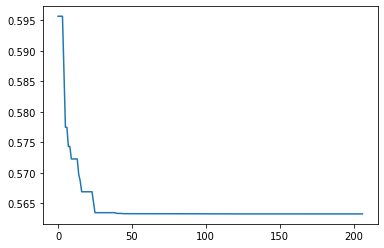

In [48]:
plt.plot( [error for _, error in swarm_AD.history] )
plt.show()

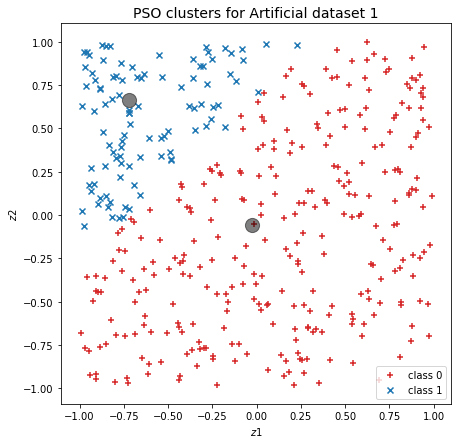

In [50]:
y_PSO_AD = swarm_AD.predict(X_AD)
plot_artificial(X_AD, y_PSO_AD, 'PSO clusters for Artificial dataset 1', centers=swarm_AD.gbest[0])

In [84]:
# Iris dataset
swarm_iris = PSO(X, 3, n_particles, omega, c1, c2, n_evals)

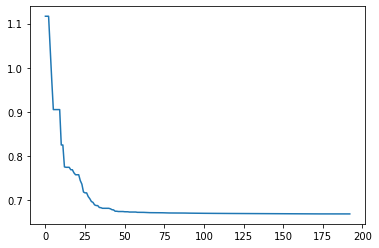

In [85]:
plt.plot( [error for _, error in swarm_iris.history] )
plt.show()

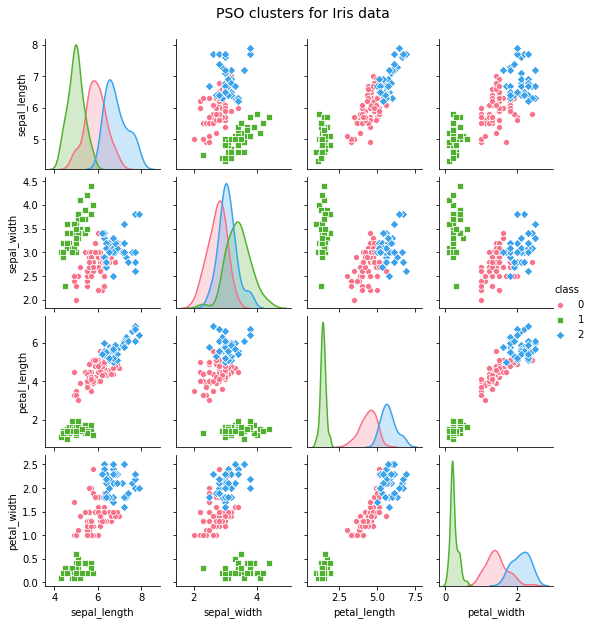

In [86]:
y_PSO = swarm_iris.predict(X)
plot_iris(X, y_PSO, 'PSO clusters for Iris data')

**Multiple runs**

In [55]:
def stats_runs(errors):
    print('mean:', np.mean(errors))
    print('best:', min(errors) )
    print('worst:', max(errors) )
    print('std:', np.std(errors))

In [56]:
# Artificial dataset 1
PSO_runs_AD = []
for _ in tqdm(range(n_simulations)):
    swarm_AD = PSO(X_AD, 2, n_particles, omega, c1, c2, n_evals, show_progress=False)
    PSO_runs_AD.append(swarm_AD)

In [57]:
PSO_errors_AD = []
for run in PSO_runs_AD:
    _, error = run.gbest
    PSO_errors_AD.append(error)

stats_runs(PSO_errors_AD)

mean: 0.5649058257371974
best: 0.5381027705345016
worst: 0.5990516117454456
std: 0.014974411710452279


In [58]:
# Iris dataset
PSO_runs_iris = []
for _ in tqdm(range(n_simulations)):
    swarm_iris = PSO(X, 3, n_particles, omega, c1, c2, n_evals, show_progress=False)
    PSO_runs_iris.append(swarm_iris)

In [59]:
PSO_errors_iris = []
for run in PSO_runs_iris:
    _, error = run.gbest
    PSO_errors_iris.append(error)

stats_runs(PSO_errors_iris)

mean: 0.7468811762913311
best: 0.6079528188211275
worst: 1.0157598338578189
std: 0.08567945891664946


### k-means clustering algorithm

In [74]:
def kmeans_clustering(X, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters, n_init = 50)
    kmeans.fit(X)

    y = kmeans.predict(X)
    centers = kmeans.cluster_centers_
    QE = quantization_error(X, centers)
    return QE, y, centers

In [75]:
QE_kmeans_iris, y_kmeans_iris, _ = kmeans_clustering(X, 3)
print('Quantization error (k-means):\n', QE_kmeans_iris)

Quantization error (k-means):
 0.6465653848597096


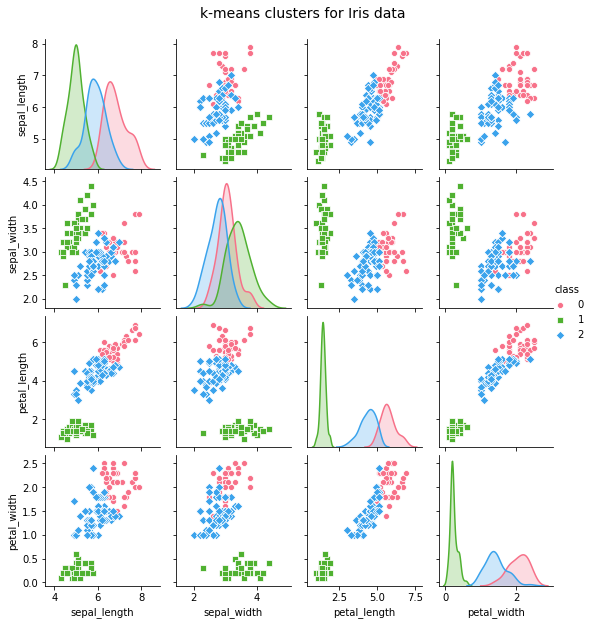

In [76]:
plot_iris(X, y_kmeans_iris, 'k-means clusters for Iris data')

In [77]:
QE_kmeans_AD, y_kmeans_AD, centers_AD = kmeans_clustering(X_AD, 2)
print('Quantization error (k-means):\n', QE_kmeans_AD)

Quantization error (k-means):
 0.5903485022557662


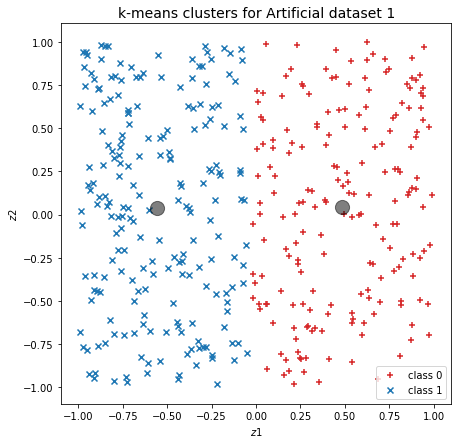

In [78]:
plot_artificial(X_AD, y_kmeans_AD, 'k-means clusters for Artificial dataset 1', centers=centers_AD)

**Multiple runs**

In [79]:
# Iris dataset
kmeans_errors_iris = []
for _ in range(n_simulations):
    QE, _, _ = kmeans_clustering(X, 3)
    kmeans_errors_iris.append(QE)
stats_runs(kmeans_errors_iris)

mean: 0.6465653848597095
best: 0.6465653848597096
worst: 0.6465653848597096
std: 1.1102230246251565e-16


In [80]:
# Artificial dataset 1
kmeans_errors_AD = []
for _ in range(n_simulations):
    QE, _, _ = kmeans_clustering(X_AD, 2)
    kmeans_errors_AD.append(QE)
stats_runs(kmeans_errors_AD)

mean: 0.5903485022557661
best: 0.5903485022557662
worst: 0.5903485022557662
std: 1.1102230246251565e-16
